In [1]:
using DataFrames, Dates
import PlotlyJS

include("../Engine/Engine.jl")
using .Engine;

WebIO._IJuliaInit()

## Load the data and format it

In [16]:
# data = load_dataset(COP26)


"""
Easily load a dataset from disk into a DataFrame.
"""
function load_dataset2(::Type{T}; N_days::Int = 13) where T <: Dataset

    if T == COP26
        datafolder = DATA_FOLDER * "/COP26_processed_lightweight/"
    elseif T == COP27
        datafolder = DATA_FOLDER * "/COP27_processed_lightweight/"
    elseif T == RandomDays 
        datafolder = DATA_FOLDER * "/Random_days_processed_lightweight/"
    end

    datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]

    # Select only a few days randomly
    if T == RandomDays
        Random.seed!(12)
        indices = sample(1:length(datafiles), N_days, replace=false)
        sort!(indices)
        datafiles = datafiles[indices]
    end

    frames = [load_json(datafolder * file) for file in datafiles]
    data = vcat(frames...)

    # Artificially change the days 
    if T == RandomDays
        process_random_dataset!(data)
    end

    return data

end


data = load_dataset2(RandomDays)

LoadError: error in method definition: function Helpers.load_dataset must be explicitly imported to be extended

## Define the partition, actors and actions

In [3]:
# partition_func = cop_26_dates
# action_func = trust_score
# actor_func = follower_count


partition_func = no_partition
action_func = trust_score
actor_func = follower_count

follower_count (generic function with 1 method)

In [4]:
agents = PreProcessingAgents(partition_func, action_func, actor_func)
df, partitions, actions, actors = preprocessing(data, agents);

## Statistics on the data

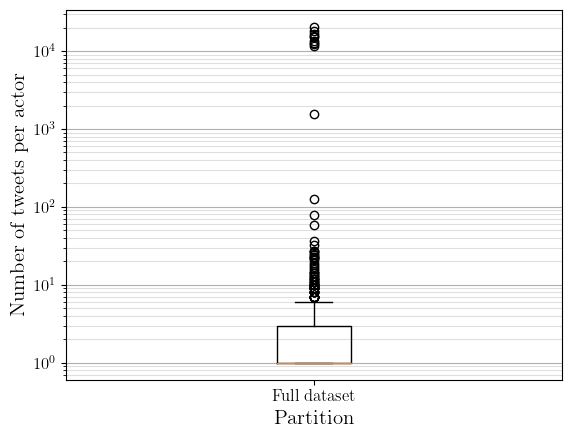

In [5]:
plot_actor_frequency(df, save=false, filename="../../Results/actor_frequency.pdf");

In [6]:
plot_actor_wordcloud(df, Nactor=300, save=false, filename="../../Results/actor_wordcloud.svg")

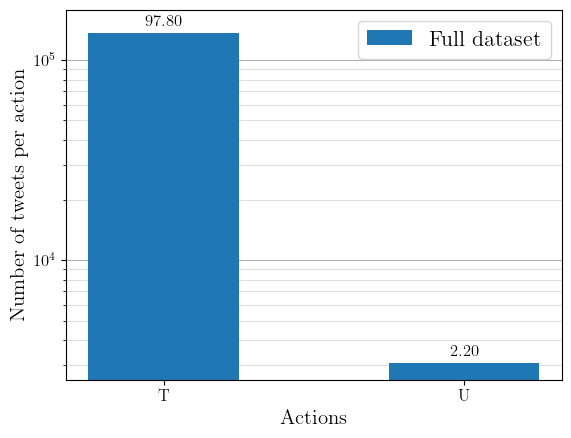

In [7]:
plot_action_frequency(df, save=false, filename="../../Results/action_frequency.pdf");

## Compute influence graph

In [8]:
hours = 2
minutes = 0;

In [9]:
total_min = hours*60 + minutes

# cuttoff = 0.5
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=false)
# ig = InfluenceGraphGenerator()
# icg = InfluenceCascadeGenerator(cuttoff)

cuttoff = 0
tsg = TimeSeriesGenerator(Minute(total_min), standardize=true)
ig = InfluenceGraphGenerator(JointDistanceDistribution, Nsurro=100, alpha=0.001, seed=1234)
icg = InfluenceCascadeGenerator(WithoutCuttoff)






# ig = InfluenceGraphGenerator(SMeasure)
# ig = InfluenceGraphGenerator(TransferEntropy)

InfluenceCascadeGenerator(0.0, true)

In [10]:
time_series = observe(df, tsg)
influence_graphs = observe(time_series, ig);

## Compute influence cascade

In [11]:
influence_cascades = observe.(influence_graphs, Ref(icg))

edge_types = [string(n1, " to ", n2) for n1 in actions for n2 in actions]
push!(edge_types, "Any Edge");

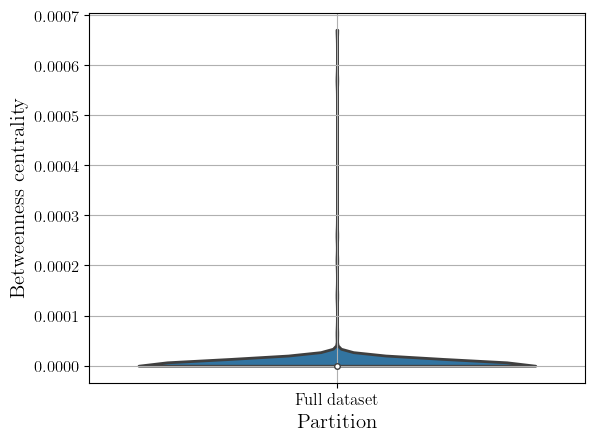

In [12]:
foo = plot_betweenness_centrality(influence_graphs, df, cuttoff, width=0.8);

## Plot influence graph

In [13]:
# partition = "During COP27"
partition = "During COP26"
# partition = "Full dataset"


edge = "Any Edge";

In [14]:
# partition_index = (1:length(partitions))[findfirst(partition .== partitions)]
	
# # In this case we plot the graph on a world map
# if actor_func == country
# 	PlotlyJS.plot(map_plot(df)...)
# # In this case we plot a simple graph of the actors
# else
# 	plot_graph(influence_graphs[partition_index], df, cuttoff, edge)
# end

LoadError: ArgumentError: invalid index: nothing of type Nothing

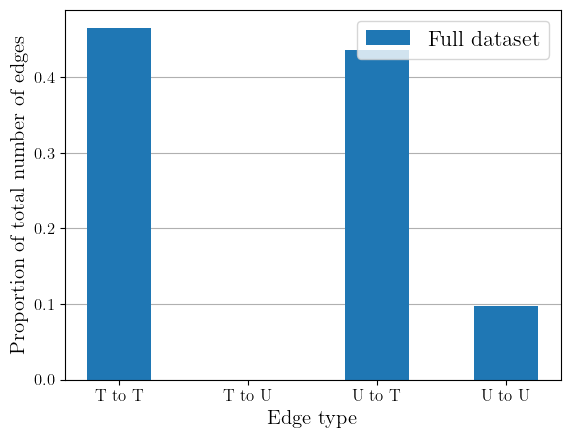

In [15]:
plot_edge_types(influence_graphs, df, cuttoff, log=false, save=false, filename="../../Results/proportion_edges_te.pdf");

In [ ]:
using DataFrames
import PyPlot as plt

function plot_edge_types2(influence_graphs::InfluenceGraphs, df::DataFrame, cuttoff::Real = 0.0; width::Real = 0.25,
    inner_spacing::Real = 0.01, outer_spacing::Real = width, log::Bool = true, save::Bool = false, filename = nothing, reorder = [2,3,1])

    if save && isnothing(filename)
        throw(ArgumentError("You must provide a filename if you want to save the figure."))
    end

    # Actions and partitions are represented in the order they appear in sort(unique(df)) in the adjacency matrix
    actions = sort(unique(df.action))
    partitions = sort(unique(df.partition))

    # In this case remove default value
    if length(partitions) != 3 && reorder == [2,3,1]
        reorder = nothing
    end

    N_actions = length(actions)
    N_partitions = length(partitions)
    
    edge_types = [string(n1, " to ", n2) for n1 in actions for n2 in actions]

    edge_number = Matrix{Int}(undef, N_partitions, N_actions^2)

    for (k, adjacency) in enumerate(influence_graphs)
        linear_index = 0
        for i = 1:N_actions, j = 1:N_actions
            linear_index += 1
            simplifier = x -> (x[i, j] > cuttoff)
            edge_number[k, linear_index] = sum(simplifier.(adjacency))
        end
    end

    # Optionally reorder the bars in the plot
    if !isnothing(reorder)
        partitions = partitions[reorder]
        edge_number = edge_number[reorder, :]
    end


    X, tick_position = Visualizations.barplot_layout(N_partitions, N_actions^2, width=width, inner_spacing=inner_spacing, outer_spacing=outer_spacing)

    plt.figure()
    for i = 1:N_partitions
        plt.bar(X[i,:], edge_number[i,:], width=width, label=partitions[i], zorder=2)
    end
    plt.xlabel("Edge type")
    plt.ylabel("Total number of edges")
    plt.legend()
    plt.grid(true, which="major", axis="y", zorder=0)
    plt.xticks(tick_position, edge_types)
    if log
        plt.yscale("log")
        plt.grid(true, which="minor", axis="y", zorder=0, alpha=0.4)
    end
    if save
        plt.savefig(filename, bbox_inches="tight", dpi=400)
    end
    return plt.gcf()

end


plot_edge_types2(influence_graphs, df, cuttoff, log=false, save=false, filename="../../Results/proportion_edges_te.pdf");

## Plot cascades and statistics

In [ ]:
partition_index = 1
influencer_indices = [ic.root for ic in influence_cascades[partition_index]]
influencers = sort(actors[influencer_indices])

In [ ]:
if length(influencers) > 0
    influencer_node1 = influencers[1]

    PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...)
    # PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...), "../../Results/cascade.pdf")
end

In [ ]:
plot_actors_per_level(influence_cascades, df, log=false, inner_spacing=0.02, save=false, filename="../../Results/mean_actor_cascade_te.pdf");